# Anomaly Detection in Sensor Data




## 1 **Approach:**
1. **Explore Data:** Analyze distributions, correlations, and temporal patterns.
2. **Preprocess:** Engineer features from the `Date`, handle missing values, and scale the data.
3. **Model:** Train and evaluate a Random Forest and a simple Neural Network (MLP).
4. **Evaluate:** Compare models using F1-score, PR-AUC, and other relevant metrics.
5. **Conclude:** Select the best model and save it for deployment.

## 2. Setup & Imports

In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os


from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve
)


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
pd.set_option('display.max_columns', 100)
import warnings
warnings.filterwarnings('ignore')


os.makedirs('models', exist_ok=True)
os.makedirs('figures', exist_ok=True)

## 3. Data Loading & Exploration

In [5]:

try:
    df_train = pd.read_csv('train.csv', parse_dates=['Date'])
    df_test = pd.read_csv('test.csv', parse_dates=['Date'])
    df_train = df_train.sort_values('Date').reset_index(drop=True)
    print('Datasets loaded and sorted successfully.')
except FileNotFoundError:
    print('Error: train.csv or test.csv not found.')
    df_train = pd.DataFrame() 

if not df_train.empty:
    display(df_train.head())

Datasets loaded and sorted successfully.


,Date,X1,X2,X3,X4,X5,target
0,2020-12-16,1.518921,5.463154,1.0,2.718282,2.890372,0
1,2020-12-16,1.185305,5.469999,1.0,7.389056,2.890372,0
2,2020-12-16,1.185305,5.469746,1.0,2.718282,2.890372,0
3,2020-12-16,1.185305,5.469241,1.0,2.718282,2.890372,0
4,2020-12-16,1.182937,5.467427,1.0,2.718282,2.890372,0


### 3.1. Basic Info & Missing Values

In [6]:
if not df_train.empty:
    df_train.info()
    print("\n--- Missing Values ---")
    print(df_train.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1639424 entries, 0 to 1639423
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   Date    1639424 non-null  datetime64[ns]
 1   X1      1639424 non-null  float64       
 2   X2      1639424 non-null  float64       
 3   X3      1639424 non-null  float64       
 4   X4      1639424 non-null  float64       
 5   X5      1639424 non-null  float64       
 6   target  1639424 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 87.6 MB

--- Missing Values ---
Date      0
X1        0
X2        0
X3        0
X4        0
X5        0
target    0
dtype: int64


### 3.2. Class Balance

target
0    1625386
1      14038
Name: count, dtype: int64


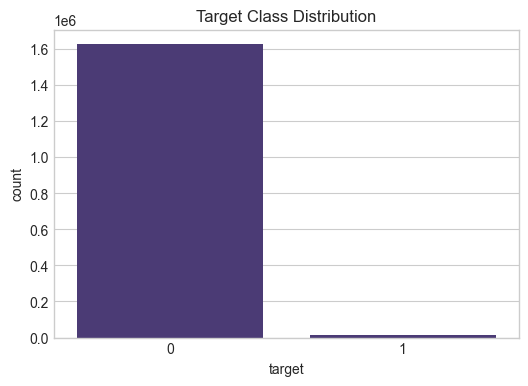

In [7]:
if not df_train.empty:
    target_counts = df_train['target'].value_counts()
    print(target_counts)
    
    plt.figure(figsize=(6, 4))
    sns.countplot(x='target', data=df_train)
    plt.title('Target Class Distribution')
    plt.show()

### 3.3. Summary Statistics & Correlation

,X1,X2,X3,X4,X5
count,1.639424e+06,1.639424e+06,1.639424e+06,1.639424e+06,1.639424e+06
mean,1.139258e+00,5.488189e+00,4.110388e+32,2.706323e+29,1.187219e+00
std,1.391992e-01,1.342811e-02,2.346156e+35,5.812988e+31,1.304814e+00
min,1.000000e+00,5.412539e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.049171e+00,5.480597e+00,1.000000e+00,1.000000e+00,0.000000e+00
50%,1.105171e+00,5.488979e+00,1.000000e+00,1.000000e+00,6.931472e-01
75%,1.214096e+00,5.496717e+00,1.000000e+00,2.718282e+00,2.890372e+00
max,4.014850e+00,5.541852e+00,1.651636e+38,5.540622e+34,3.465736e+00


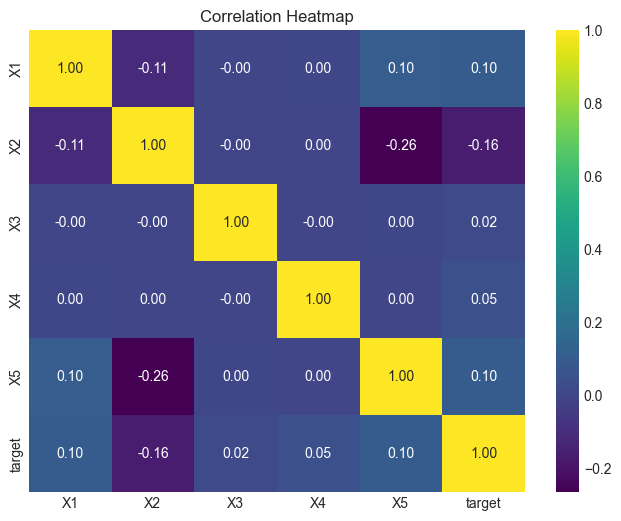

In [8]:
if not df_train.empty:
    sensor_cols = [f'X{i}' for i in range(1, 6)]
    display(df_train[sensor_cols].describe())
    
    corr_matrix = df_train[sensor_cols + ['target']].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()

## 4. Preprocessing & Feature Engineering

In [9]:
def feature_engineer(df):
    """Extracts time-based features from the Date column."""
    df['hour'] = df['Date'].dt.hour
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df = df.drop('Date', axis=1)
    return df

if not df_train.empty:
    df_train_featured = feature_engineer(df_train.copy())
    display(df_train_featured.head())

,X1,X2,X3,X4,X5,target,hour,dayofweek,month
0,1.518921,5.463154,1.0,2.718282,2.890372,0,0,2,12
1,1.185305,5.469999,1.0,7.389056,2.890372,0,0,2,12
2,1.185305,5.469746,1.0,2.718282,2.890372,0,0,2,12
3,1.185305,5.469241,1.0,2.718282,2.890372,0,0,2,12
4,1.182937,5.467427,1.0,2.718282,2.890372,0,0,2,12


### 4.1. Data Splitting & Preprocessing Pipeline

In [10]:
if not df_train.empty:
    X = df_train_featured.drop('target', axis=1)
    y = df_train_featured['target']
    
 
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')

    preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ])

Train shape: (1311539, 8), Test shape: (327885, 8)


## 5. Modeling

### 5.1. Random Forest

In [11]:
if not df_train.empty:
    
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
    ])
    
    
    rf_pipeline.fit(X_train, y_train)
    
   
    y_pred_rf = rf_pipeline.predict(X_test)
    y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]
    print('Random Forest model trained.')

Random Forest model trained.


### 5.2. Neural Network (MLP)

In [12]:
if not df_train.empty:
    # Preprocess data for NN separately
    X_train_nn = preprocessor.fit_transform(X_train)
    X_test_nn = preprocessor.transform(X_test)
    
    # Define the model
    def create_mlp(input_shape):
        model = Sequential([
            Dense(32, activation='relu', input_shape=(input_shape,)),
            BatchNormalization(),
            Dropout(0.3),
            Dense(16, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(1, activation='sigmoid') 
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
        return model

    mlp_model = create_mlp(X_train_nn.shape[1])
    mlp_model.summary()
    
  
    neg, pos = np.bincount(y_train)
    total = neg + pos
    class_weight_nn = {0: (1 / neg) * (total / 2.0), 1: (1 / pos) * (total / 2.0)}

   
    history = mlp_model.fit(
        X_train_nn, y_train, 
        epochs=20, 
        batch_size=256, 
        validation_split=0.2, 
        class_weight=class_weight_nn,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
        verbose=1
    )
    
    
    y_prob_mlp = mlp_model.predict(X_test_nn).flatten()
    y_pred_mlp = (y_prob_mlp > 0.5).astype(int)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,025 (4.00 KB)

 Trainable params: 929 (3.63 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/20
4099/4099 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - AUC: 0.8148 - loss: 0.5762 - val_AUC: 0.5000 - val_loss: 1.0006
Epoch 2/20
4099/4099 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - AUC: 0.8271 - loss: 0.5075 - val_AUC: 0.5000 - val_loss: 1.1260
Epoch 3/20
4099/4099 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.7814 - loss: 0.5462 - val_AUC: 0.5000 - val_loss: 1.2839
Epoch 4/20
4099/4099 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - AUC: 0.7594 - loss: 0.5667 - val_AUC: 0.5000 - val_loss: 1.2321
10247/10247 ━━━━━━━━━━━━━━━━━━━━ 8s 753us/step


## 6. Evaluation

--- Random Forest Evaluation ---
Accuracy: 0.9971
Precision: 0.7915
Recall: 0.4034
F1-Score: 0.5345
ROC-AUC: 0.9700


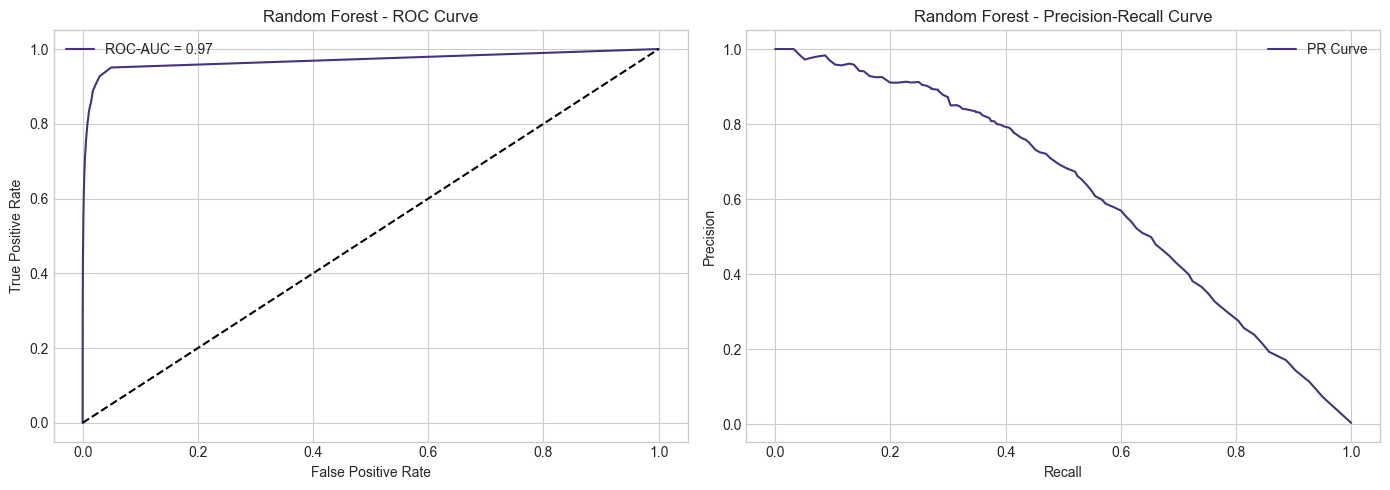

--- MLP Evaluation ---
Accuracy: 0.0041
Precision: 0.0041
Recall: 1.0000
F1-Score: 0.0081
ROC-AUC: 0.5000


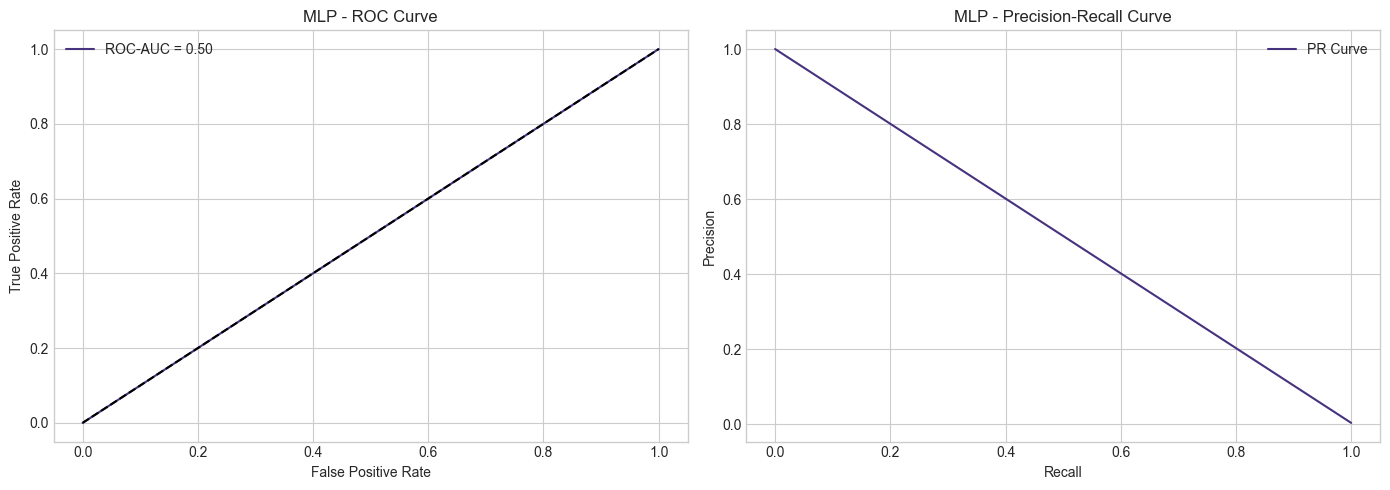

In [13]:
def evaluate_model(y_true, y_pred, y_prob, model_name='Model'):
    """Calculates and prints key classification metrics."""
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_prob)
    }
    print(f'--- {model_name} Evaluation ---')
    for name, value in metrics.items():
        print(f'{name}: {value:.4f}')
    return metrics

def plot_curves(y_true, y_prob, model_name):
    """Plots ROC and Precision-Recall curves."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    ax1.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc_score(y_true, y_prob):.2f}')
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_title(f'{model_name} - ROC Curve')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.legend()
    
  
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ax2.plot(recall, precision, label='PR Curve')
    ax2.set_title(f'{model_name} - Precision-Recall Curve')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

if not df_train.empty:
    rf_metrics = evaluate_model(y_test, y_pred_rf, y_prob_rf, 'Random Forest')
    plot_curves(y_test, y_prob_rf, 'Random Forest')
    
    mlp_metrics = evaluate_model(y_test, y_pred_mlp, y_prob_mlp, 'MLP')
    plot_curves(y_test, y_prob_mlp, 'MLP')

### 6.1. Model Comparison & Feature Importance

--- Model Comparison ---


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Random Forest,0.997136,0.791483,0.403443,0.534457,0.969992
MLP,0.004075,0.004075,1.000000,0.008116,0.500000


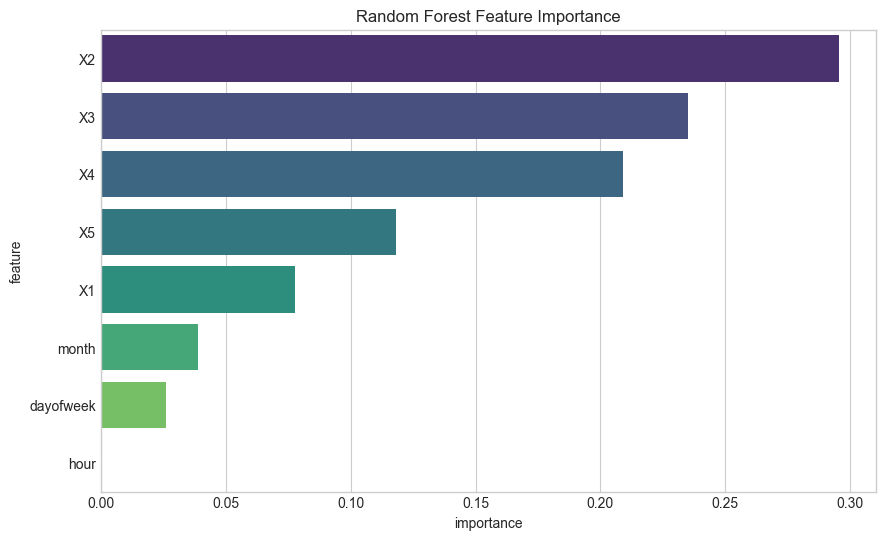

In [14]:
if not df_train.empty:
   
    comparison_df = pd.DataFrame([rf_metrics, mlp_metrics], index=['Random Forest', 'MLP'])
    print('--- Model Comparison ---')
    display(comparison_df)
    
    
    feature_names = X_train.columns
    importances = rf_pipeline.named_steps['classifier'].feature_importances_
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    importance_df = importance_df.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')
    plt.title('Random Forest Feature Importance')
    plt.show()

## 7. Conclusion & Model Saving

In [15]:
print('Based on the F1-Score and ROC-AUC, the Random Forest model appears to perform better.')
print('It provides a good balance of precision and recall for this imbalanced problem.')


model_path = 'models/random_forest_pipeline.joblib'
joblib.dump(rf_pipeline, model_path)
print(f'Best model saved to {model_path}')

#
mlp_model_path = 'models/mlp_model.h5'
mlp_model.save(mlp_model_path)

joblib.dump(preprocessor, 'models/mlp_preprocessor.joblib')
print(f'MLP model saved to {mlp_model_path}')

Based on the F1-Score and ROC-AUC, the Random Forest model appears to perform better.
It provides a good balance of precision and recall for this imbalanced problem.
Best model saved to models/random_forest_pipeline.joblib
MLP model saved to models/mlp_model.h5
